<a href="https://colab.research.google.com/github/praveenraghuvanshi1512/EVA4/blob/Session-12/Session-12/Assignment-12/Assignment-12-A/EVA_4_S12_A_Praveen_Raghuvanshi_Main_52_27.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Steps Summary

In [0]:
# 1. Mount google drive
# 2. Set the directory path of google drive
# 3. Load and Import all modules and libraries
# 4. Set Device
# 5. Import all the functions
# 6. Load transformations
# 7. Load dataset
# 8. Load Classes
# 9. Display sample images
# 10. Load Resnet18 Model
# 11. Define Loss function and optimizer
# 12. Run train and test
# 13. Grad-CAM
# 14. Misclassified images

### 1. Mount google drive

In [0]:
# Load data from Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2. Set the directory path of google drive

In [0]:
import sys

%load_ext autoreload
%autoreload 2

BASE_COLAB_PATH = '/content/drive/My Drive/eva-4/assignment-12/assignment-12-A/' 

sys.path.append(BASE_COLAB_PATH)
sys.path.append(BASE_COLAB_PATH + 'models')
sys.path.append(BASE_COLAB_PATH + 'gradcam')
sys.path.append(BASE_COLAB_PATH + 'sampleimages')
sys.path.append(BASE_COLAB_PATH + 'misclassified')

In [0]:
cd '/content/drive/My Drive/eva-4/assignment-12/assignment-12-A'

/content/drive/My Drive/eva-4/assignment-12/assignment-12-A


In [0]:
ls

augmentation.py                                           misclassified.png
CODE_ONLY_EVA_4_S11_Praveen_Raghuvanshi_Main_91_04.ipynb  models/
cyclic-lr-plot.JPG                                        outputs/
data/                                                     plotutils.py
EVA_4_S12_Praveen_Raghuvanshi_Main.ipynb                  __pycache__/
gradcam/                                                  S12_functions.py
IMagenet/                                                 sampleimages/
learningrate.py                                           tiny-imagenet-200.zip
metrics.png                                               utils.py


### 3. Load and Import all modules and libraries

In [0]:
!pip install torchsummary

In [0]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-38z_a4kq
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-38z_a4kq
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65099 sha256=ba5d4c7eba82702441f03084d64f2168cecf9c9bb62fa201ea2f0cb454ffa597
  Stored in directory: /tmp/pip-ephem-wheel-cache-ymv03q_g/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.4.5
    Uninstalling albumentations-0.4.5:
      Successfully uninstalled albumentations-0.4.5


In [0]:
!pip install torch-lr-finder -v --global-option="amp"

In [0]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from os import path
from torchvision.utils import make_grid
from torchsummary import summary

In [0]:
# Define hyper paramteres and constants
EPOCHS=50
BATCH_SIZE=512
IMAGENET_ROOT_DIR = BASE_COLAB_PATH + 'IMagenet/tiny-imagenet-200/'
IMAGENET_TRAIN_SET_DIR = "train_set"
IMAGENET_TEST_SET_DIR = "test_set"
IMAGENET_TRAIN_SET_DIR_PATH = IMAGENET_ROOT_DIR + IMAGENET_TRAIN_SET_DIR
IMAGENET_TEST_SET_DIR_PATH = IMAGENET_ROOT_DIR + IMAGENET_TEST_SET_DIR

trainaccuracies = []
trainlosses = []
testlosses = []
testaccuracies = []
lr_values = []

### 4. Set Device

In [0]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


###  5. Import all the functions

In [0]:
from model import Net, ResNet, resnet18
from s11model import S11Model
from S12_functions import myfunc, transformations, loadcifar10dataset, getclasses, display, train, test, imshow, loadimage, saveimage
from S12_functions import loadimagenetdataset, splittinyimagedataset, getloss, getoptimizer, getscheduler
from gradcam import GradCAM, GradCAMpp, applygradcam
from gradcam_utils import Normalize, visualize_cam
from learningrate import findandplotlearningrate, plotCyclicLR, performLRRangeTest, getSchdeduler, getlr
from plotutils import plotimages, plotmisclassifiedimages, savemisclassifiedimages, plotmisclassifiedgradcamimages, plotmetrics 

###  6. Load Transformations

In [0]:
transform_train, transform_test = transformations()

###  7. Load Dataset

In [0]:
if not path.exists(IMAGENET_TRAIN_SET_DIR_PATH):
  ! git clone https://github.com/seshuad/IMagenet 
  ! ls 'IMagenet/tiny-imagenet-200/'
  os.chdir(BASE_COLAB_PATH + 'IMagenet/')
  splittinyimagedataset()

print(path.exists(IMAGENET_TRAIN_SET_DIR_PATH))

True


In [0]:
!pwd
os.chdir('/content/drive/My Drive/eva-4/assignment-12/assignment-12-A/IMagenet/tiny-imagenet-200/')
!pwd

/content/drive/My Drive/eva-4/assignment-12/assignment-12-A
/content/drive/My Drive/eva-4/assignment-12/assignment-12-A/IMagenet/tiny-imagenet-200


In [0]:
trainset, trainloader, testset, testloader = loadimagenetdataset(train_dir=IMAGENET_TRAIN_SET_DIR, test_dir=IMAGENET_TEST_SET_DIR, transform_train=transform_train, transform_test=transform_test, batch_size=BATCH_SIZE)
print(trainloader)

Preparing data loaders ...


### 9. Display sample images

###### Sample Training Images

In [0]:
plotimages(device, classes, trainloader, 5)

IndexError: ignored

<Figure size 720x648 with 0 Axes>

###### Sample Test Images

In [0]:
plotimages(device, classes, testloader, 20)

### 10. Load Resnet18 Model


In [0]:
print("Building Model")
net = resnet18(numberofClasses=200)

Building Model


In [0]:
# Display Model Summary
model = net.to(device)
summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

### 11. Define loss function and optimizer


In [0]:
criterion = getloss()

#### Find Learning Rate

In [0]:
optimizer = getoptimizer(model, lr=1e-7, momentum=0.9, nesterov=True, weight_decay=0.05)

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


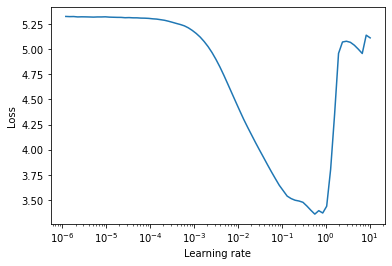

0.562341


In [0]:
max_lr = performLRRangeTest(model, optimizer, criterion, device, trainloader, end_lr=100, num_iter=100)

In [0]:
scheduler = getSchdeduler(optimizer, max_lr = 0.0125, epochs=EPOCHS, steps_per_epoch=1, pct_start=0.4)

### 12. Run Train and Test

In [0]:
for epoch in range(1, EPOCHS + 1):
    epochlr = getlr(optimizer)
    print("\nEPOCH:", epoch,'LR:',epochlr)
    lr_values.append(epochlr)
 
    train(model, trainloader, device, optimizer, criterion, trainaccuracies, trainlosses, epoch)
    scheduler.step()
    testloss = test(model, testloader, device, criterion, testaccuracies, testlosses, epoch)


EPOCH: 1 LR: 0.00125

Epoch: 1
 [===========================================================>.....]  Step: 155ms | Tot: 6s218ms | Train >> Loss: 4.867 | Acc: 3.380% (182/5385) 11/11 
 [======================================================>..........]  Step: 40ms | Tot: 2s134ms | Test >> Loss: 4.751 | Acc: 6.525% (184/2820) 6/6 

EPOCH: 2 LR: 0.001842105263157895

Epoch: 2
 [===========================================================>.....]  Step: 169ms | Tot: 6s309ms | Train >> Loss: 3.464 | Acc: 9.972% (537/5385) 11/11 
 [======================================================>..........]  Step: 41ms | Tot: 2s145ms | Test >> Loss: 3.481 | Acc: 10.957% (309/2820) 6/6 

EPOCH: 3 LR: 0.0024342105263157896

Epoch: 3
 [===========================================================>.....]  Step: 209ms | Tot: 6s373ms | Train >> Loss: 2.811 | Acc: 12.943% (697/5385) 11/11 
 [======================================================>..........]  Step: 37ms | Tot: 2s90ms | Test >> Loss: 3.036 | Acc:

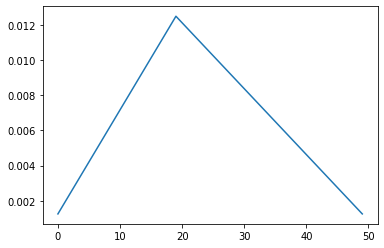

In [0]:
plt.plot(lr_values)

#### Plot Metrics - Accuracy and Loss

50
50


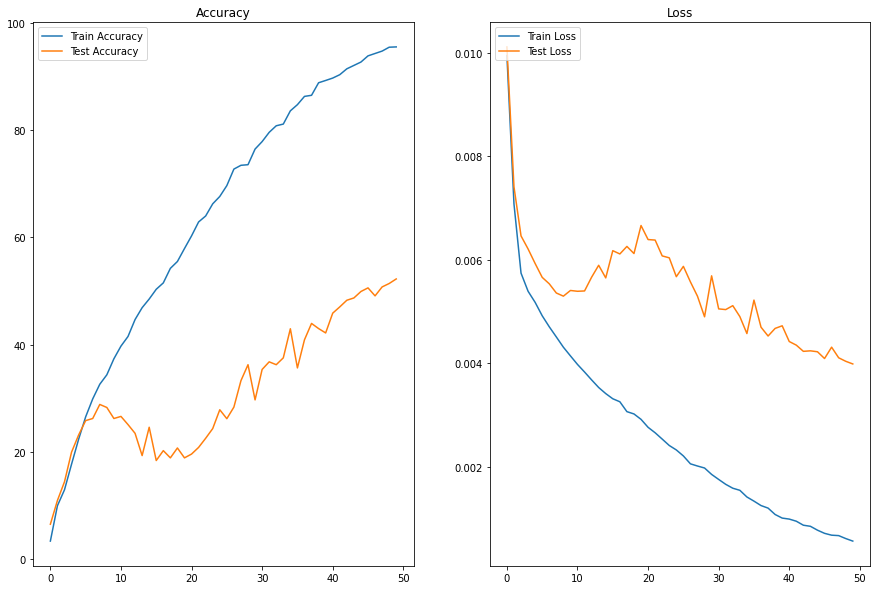

In [0]:
plotmetrics(trainaccuracies, testaccuracies, trainlosses, testlosses, savefilename="metrics")

### 14. Misclassified images

#### Get Misclassified Images

In [0]:
misclassifieddirectory = '/content/drive/My Drive/eva-4/assignment-11/misclassified'
names, titles = savemisclassifiedimages(model, device, classes, testloader, misclassifieddirectory, 25)

### 15. Analysis
- No of Epochs : 50
- Batch size : 512
- Best Test  Acc: 52.270%
- Model: ResNet18
- Cutout : Yes
- Albumentations: Yes
- Hyperparameters
  - Optimizer: SGD
  - Learning rate: 0.0125
  - Momentum: 0.9
  - Scheduler: One Cycle Policy